In [1]:
# 3 h 15m, 36 epochs

from classifier import *
from datasets import *
import os

torch.multiprocessing.set_sharing_strategy('file_system')

cwd = os.getcwd()
os.chdir('..')

In [2]:
import os

name = 'all_in_one_test'
version = 1

model = Net(classes)

logger = pl.loggers.TensorBoardLogger('lightning_logs', name=name, version=version)
trainer = pl.Trainer(
    accelerator='gpu',
    devices=1,
    max_epochs=-1,
    logger=logger,
    log_every_n_steps=20,
    callbacks=[
        pl.callbacks.progress.TQDMProgressBar(refresh_rate=20),
        pl.callbacks.ModelCheckpoint(monitor="val_loss", save_last=True, save_top_k=3, filename='{epoch}-{val_loss:.3f}-{val_acc:.3f}')
    ],
)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [5]:
testloader = data.DataLoader(EvalSet(split='val', corner_sinks_ratio=None), batch_size=64, num_workers=6)

In [6]:
trainer.test(model, testloader, ckpt_path='lightning_logs/all_in_one/version_1/checkpoints/epoch=2-val_loss=0.285-val_acc=0.916.ckpt')

Restoring states from the checkpoint path at lightning_logs/all_in_one/version_1/checkpoints/epoch=2-val_loss=0.285-val_acc=0.916.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at lightning_logs/all_in_one/version_1/checkpoints/epoch=2-val_loss=0.285-val_acc=0.916.ckpt


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.9335215091705322
        test_loss           0.22293449938297272
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.22293449938297272, 'test_acc': 0.9335215091705322}]

In [5]:
# trainer.test(model, testloader, ckpt_path='lightning_logs/all_in_one/version_1/checkpoints/epoch=20-val_loss=0.289-val_acc=0.921.ckpt')

Restoring states from the checkpoint path at lightning_logs/all_in_one/version_1/checkpoints/epoch=20-val_loss=0.289-val_acc=0.921.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at lightning_logs/all_in_one/version_1/checkpoints/epoch=20-val_loss=0.289-val_acc=0.921.ckpt


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc             0.935114860534668
        test_loss           0.22376705706119537
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.22376705706119537, 'test_acc': 0.935114860534668}]

In [5]:
# trainer.test(model, testloader, ckpt_path='lightning_logs/all_in_one/version_1/checkpoints/epoch=25-val_loss=0.291-val_acc=0.931.ckpt')

Restoring states from the checkpoint path at lightning_logs/all_in_one/version_1/checkpoints/epoch=25-val_loss=0.291-val_acc=0.931.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at lightning_logs/all_in_one/version_1/checkpoints/epoch=25-val_loss=0.291-val_acc=0.931.ckpt


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.9392288327217102
        test_loss           0.28816190361976624
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.28816190361976624, 'test_acc': 0.9392288327217102}]

In [ ]:
# testloader = data.DataLoader(EvalSet(split='test', corner_sinks_ratio=None, n_toilet_samples=2000, n_sink_samples=2000), batch_size=1, num_workers=1)
# import time
# start = time.time()
# iters = 1
# for i in range(iters):
#     trainer.test(model, testloader, ckpt_path=f'lightning_logs/all_in_one/version_2/checkpoints/epoch=13-val_loss=0.723-val_acc=0.879.ckpt')
# print((time.time() - start)/iters)

In [7]:
from tqdm import tqdm

# testloader = data.DataLoader(EvalSet(split='test', corner_sinks_ratio=None, n_toilet_samples=2000, n_sink_samples=2000), batch_size=1, num_workers=1)
testloader = data.DataLoader(EvalSet(split='val', corner_sinks_ratio=None), batch_size=64, num_workers=0)

all_preds = []
all_gt = []
model.eval()
with torch.no_grad():
    for x, y in tqdm(testloader):
        preds = model(x).argmax(1).numpy()
        all_preds.append(list(preds))
        all_gt.append(y.numpy())

all_preds = torch.as_tensor(np.array([item for sublist in all_preds for item in sublist]))
all_gt = torch.as_tensor(np.array([item for sublist in all_gt for item in sublist]))

100%|██████████| 283/283 [04:55<00:00,  1.04s/it]


In [10]:
cm = tm.ConfusionMatrix(len(classes))
matrix = cm(all_preds, all_gt).numpy()

In [25]:
from sklearn import metrics

cr = metrics.classification_report(all_gt, all_preds, target_names=[str(c) for c in classes], digits=4)

In [26]:
tp = np.diag(matrix)
acc = tp/np.sum(matrix, axis=1)
precision = tp/np.sum(matrix, axis=0)

In [27]:
from tqdm import tqdm

# evalset = EvalSet(split='test', corner_sinks_ratio=None, n_toilet_samples=2000, n_sink_samples=2000)
evalset = EvalSet(split='val', corner_sinks_ratio=None)
print(len(evalset))
testloader = data.DataLoader(evalset, batch_size=1, num_workers=0)

all_preds = []
all_gt = []
model.eval()
with torch.no_grad():
    for idx, (x, y) in tqdm(enumerate(testloader)):
        
        filename = evalset.all_files[idx]
        preds = model(x)

        if 'doors' in filename:
            preds = preds[:, :13].argmax(1).numpy()
        elif 'toilets' in filename:
            preds = preds[:, 13:-1].argmax(1).numpy() + 13
        else:
            preds = preds[:, 13:].argmax(1).numpy() + 13

        all_preds.append(list(preds))
        all_gt.append(y.numpy())

all_preds = torch.as_tensor(np.array([item for sublist in all_preds for item in sublist]))
all_gt = torch.as_tensor(np.array([item for sublist in all_gt for item in sublist]))

18066it [13:00, 23.16it/s]


In [29]:
cm = tm.ConfusionMatrix(len(classes))
matrix_cond = cm(all_preds, all_gt).numpy()
cr_cond = metrics.classification_report(all_gt, all_preds, target_names=[str(c) for c in classes], digits=4)

In [32]:
tp_cond = np.diag(matrix_cond)
acc_cond = tp_cond/np.sum(matrix_cond, axis=1)
precision_cond = tp_cond/np.sum(matrix_cond, axis=0)

In [59]:
from scipy import linalg

doors_cm = np.loadtxt('doors_notebooks/doors_cm-val.txt', dtype=int)
toilets_cm = np.loadtxt('report_toilets/toilets_cm-val.txt', dtype=int)
sinks_cm = np.loadtxt('report_sinks/sinks_cm-val.txt', dtype=int)

toilets_expanded = np.hstack((toilets_cm, np.zeros((toilets_cm.shape[0], 1), dtype=int)))
toilets_expanded = np.vstack((toilets_expanded, np.zeros((1, toilets_expanded.shape[1]), dtype=int)))
toilets_and_sinks = toilets_expanded + sinks_cm

total = linalg.block_diag(doors_cm, toilets_and_sinks)

tp_separate = np.diag(total)
acc_separate = tp_separate/np.sum(total, axis=1)
precision_separate = tp_separate/np.sum(total, axis=0)

In [ ]:
assert np.sum(total) == np.sum(matrix) == np.sum(matrix_cond)

Normal matrix


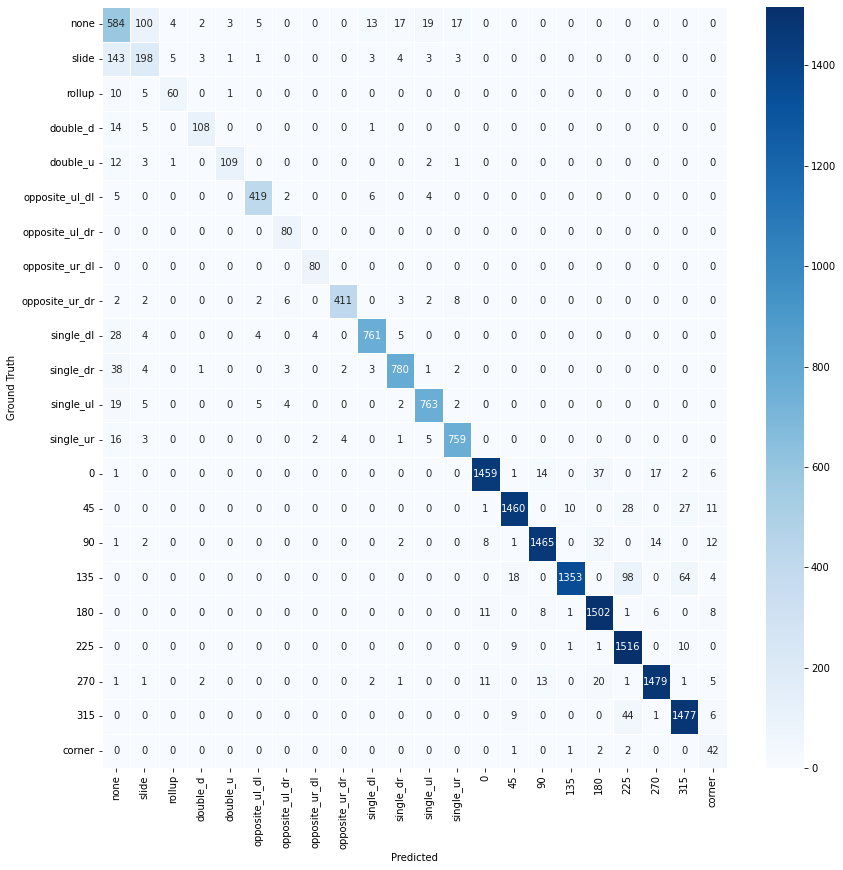

Conditional matrix


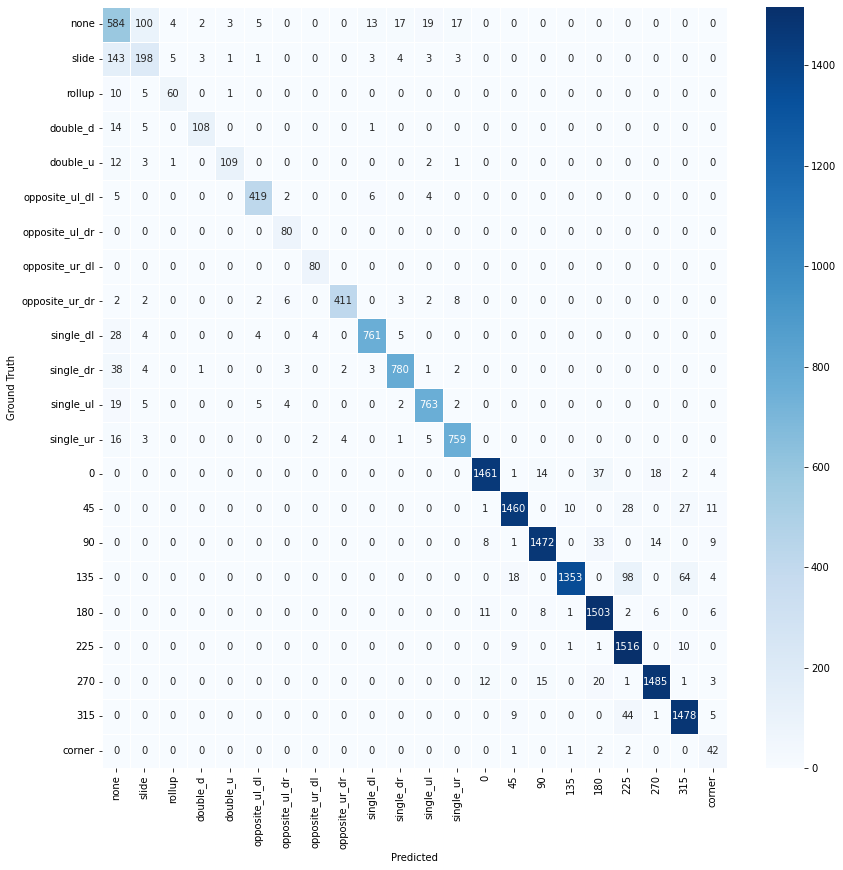

normal results
class,none,slide,rollup,double_d,double_u,opposite_ul_dl,opposite_ul_dr,opposite_ur_dl,opposite_ur_dr,single_dl,single_dr,single_ul,single_ur,0,45,90,135,180,225,270,315,corner
accuracy,76.44,54.40,78.95,84.38,85.16,96.10,100.00,100.00,94.27,94.42,93.53,95.38,96.08,94.93,94.99,95.32,88.03,97.72,98.63,96.23,96.10,87.50
precision,66.82,59.64,85.71,93.10,95.61,96.10,84.21,93.02,98.56,96.45,95.71,95.49,95.83,97.92,97.40,97.67,99.05,94.23,89.70,97.50,93.42,44.68

conditional results
class,none,slide,rollup,double_d,double_u,opposite_ul_dl,opposite_ul_dr,opposite_ur_dl,opposite_ur_dr,single_dl,single_dr,single_ul,single_ur,0,45,90,135,180,225,270,315,corner
accuracy,76.44,54.40,78.95,84.38,85.16,96.10,100.00,100.00,94.27,94.42,93.53,95.38,96.08,95.06,94.99,95.77,88.03,97.79,98.63,96.62,96.16,87.50
precision,67.05,60.18,85.71,94.74,95.61,96.10,84.21,93.02,98.56,96.70,96.06,95.49,95.83,97.86,97.40,97.55,99.05,94.17,89.65,97.44,93.43,50.00


In [39]:
import seaborn as sn

print('Normal matrix')
plt.figure(figsize=(14, 14))
ax = plt.axes()
ax = sn.heatmap(matrix, annot=True, fmt='g', cmap='Blues', linewidth=.5, xticklabels=classes, yticklabels=classes, ax=ax)
plt.xlabel('Predicted')
plt.ylabel('Ground Truth')
plt.savefig('all_in_one/all_in_one_results-val.svg')
plt.show()

print('Conditional matrix')
plt.figure(figsize=(14, 14))
ax = plt.axes()
ax = sn.heatmap(matrix_cond, annot=True, fmt='g', cmap='Blues', linewidth=.5, xticklabels=classes, yticklabels=classes, ax=ax)
plt.xlabel('Predicted')
plt.ylabel('Ground Truth')
plt.savefig('all_in_one/all_in_one_conditional_results-val.svg')
plt.show()
print('normal results')
print('class,'+ ','.join([str(c) for c in classes]))
print('accuracy,'+ ','.join([f'{el*100:4.2f}' for el in acc]))
print('precision,'+ ','.join([f'{el*100:4.2f}' for el in precision]))

print()
print('conditional results')
print('class,'+ ','.join([str(c) for c in classes]))
print('accuracy,'+ ','.join([f'{el*100:4.2f}' for el in acc_cond]))
print('precision,'+ ','.join([f'{el*100:4.2f}' for el in precision_cond]))

In [43]:
print(cr)

                precision    recall  f1-score   support

          none     0.6682    0.7644    0.7131       764
         slide     0.5964    0.5440    0.5690       364
        rollup     0.8571    0.7895    0.8219        76
      double_d     0.9310    0.8438    0.8852       128
      double_u     0.9561    0.8516    0.9008       128
opposite_ul_dl     0.9610    0.9610    0.9610       436
opposite_ul_dr     0.8421    1.0000    0.9143        80
opposite_ur_dl     0.9302    1.0000    0.9639        80
opposite_ur_dr     0.9856    0.9427    0.9637       436
     single_dl     0.9645    0.9442    0.9542       806
     single_dr     0.9571    0.9353    0.9460       834
     single_ul     0.9549    0.9537    0.9543       800
     single_ur     0.9583    0.9608    0.9595       790
             0     0.9792    0.9493    0.9640      1537
            45     0.9740    0.9499    0.9618      1537
            90     0.9767    0.9532    0.9648      1537
           135     0.9905    0.8803    0.9321  

In [44]:
print(cr_cond)

                precision    recall  f1-score   support

          none     0.6705    0.7644    0.7144       764
         slide     0.6018    0.5440    0.5714       364
        rollup     0.8571    0.7895    0.8219        76
      double_d     0.9474    0.8438    0.8926       128
      double_u     0.9561    0.8516    0.9008       128
opposite_ul_dl     0.9610    0.9610    0.9610       436
opposite_ul_dr     0.8421    1.0000    0.9143        80
opposite_ur_dl     0.9302    1.0000    0.9639        80
opposite_ur_dr     0.9856    0.9427    0.9637       436
     single_dl     0.9670    0.9442    0.9554       806
     single_dr     0.9606    0.9353    0.9478       834
     single_ul     0.9549    0.9537    0.9543       800
     single_ur     0.9583    0.9608    0.9595       790
             0     0.9786    0.9506    0.9644      1537
            45     0.9740    0.9499    0.9618      1537
            90     0.9755    0.9577    0.9665      1537
           135     0.9905    0.8803    0.9321  

Separate matrix


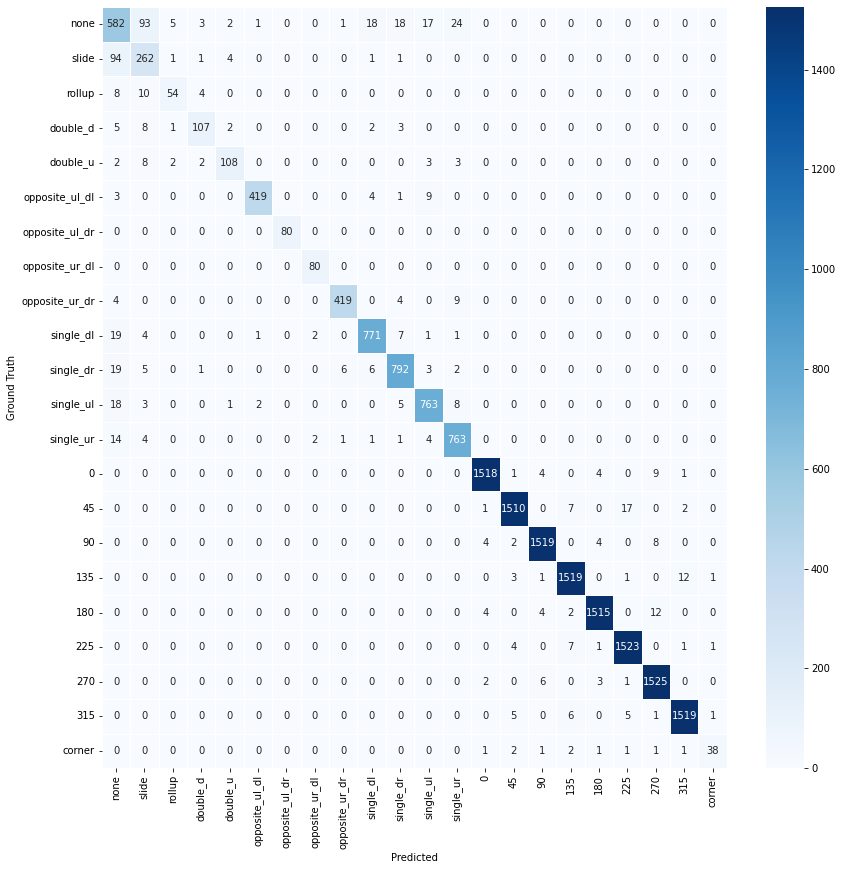

separate results
class,none,slide,rollup,double_d,double_u,opposite_ul_dl,opposite_ul_dr,opposite_ur_dl,opposite_ur_dr,single_dl,single_dr,single_ul,single_ur,0,45,90,135,180,225,270,315,corner
accuracy,76.18,71.98,71.05,83.59,84.38,96.10,100.00,100.00,96.10,95.66,94.96,95.38,96.58,98.76,98.24,98.83,98.83,98.57,99.09,99.22,98.83,79.17
precision,75.78,65.99,85.71,90.68,92.31,99.05,100.00,95.24,98.13,96.01,95.19,95.38,94.20,99.22,98.89,98.96,98.44,99.15,98.39,98.01,98.89,92.68


In [60]:
import seaborn as sn

print('Separate matrix')
plt.figure(figsize=(14, 14))
ax = plt.axes()
ax = sn.heatmap(total, annot=True, fmt='g', cmap='Blues', linewidth=.5, xticklabels=classes, yticklabels=classes, ax=ax)
plt.xlabel('Predicted')
plt.ylabel('Ground Truth')
plt.savefig('all_in_one/all_in_one_separate_results-val.svg')
plt.show()
print('separate results')
print('class,'+ ','.join([str(c) for c in classes]))
print('accuracy,'+ ','.join([f'{el*100:4.2f}' for el in acc_separate]))
print('precision,'+ ','.join([f'{el*100:4.2f}' for el in precision_separate]))

In [71]:
def classification_report_from_confusion_matrix(confusion_matrix, **args):

    y_true = np.zeros(np.sum(confusion_matrix), dtype=int)
    y_pred = np.copy(y_true)

    i = 0
    for target in range(len(confusion_matrix)):
        for pred in range(len(confusion_matrix)):
            n = confusion_matrix[target][pred]
            y_true[i:i+n] = target
            y_pred[i:i+n] = pred
            i += n

    return metrics.classification_report(y_true, y_pred, **args)

print(classification_report_from_confusion_matrix(total, target_names=[str(c) for c in classes], digits=4))

                precision    recall  f1-score   support

          none     0.7578    0.7618    0.7598       764
         slide     0.6599    0.7198    0.6886       364
        rollup     0.8571    0.7105    0.7770        76
      double_d     0.9068    0.8359    0.8699       128
      double_u     0.9231    0.8438    0.8816       128
opposite_ul_dl     0.9905    0.9610    0.9756       436
opposite_ul_dr     1.0000    1.0000    1.0000        80
opposite_ur_dl     0.9524    1.0000    0.9756        80
opposite_ur_dr     0.9813    0.9610    0.9710       436
     single_dl     0.9601    0.9566    0.9584       806
     single_dr     0.9519    0.9496    0.9508       834
     single_ul     0.9537    0.9537    0.9537       800
     single_ur     0.9420    0.9658    0.9538       790
             0     0.9922    0.9876    0.9899      1537
            45     0.9889    0.9824    0.9856      1537
            90     0.9896    0.9883    0.9889      1537
           135     0.9844    0.9883    0.9864  

In [12]:
trainloader = data.DataLoader(TrainSet(), batch_size=1, sampler=get_train_sampler(num_samples=30000), num_workers=0)
valloader = data.DataLoader(EvalSet(n_toilet_samples=2000, n_sink_samples=2000), batch_size=1, num_workers=0)

In [33]:
d = {c: 0 for c in classes}

for x, y in trainloader:
    cls = classes[y]
    d[cls] += 1

<BarContainer object of 22 artists>

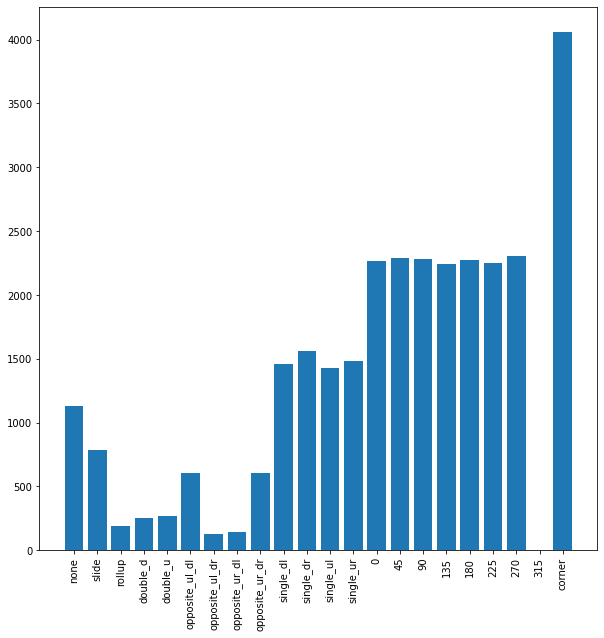

In [44]:
plt.figure(figsize=(10, 10))
plt.xticks(rotation='vertical')
plt.bar(range(len(d)), list(d.values()), tick_label=list(d.keys()))

In [45]:
d_val = {c: 0 for c in classes}

for x, y in valloader:
    cls = classes[y]
    d_val[cls] += 1

<BarContainer object of 22 artists>

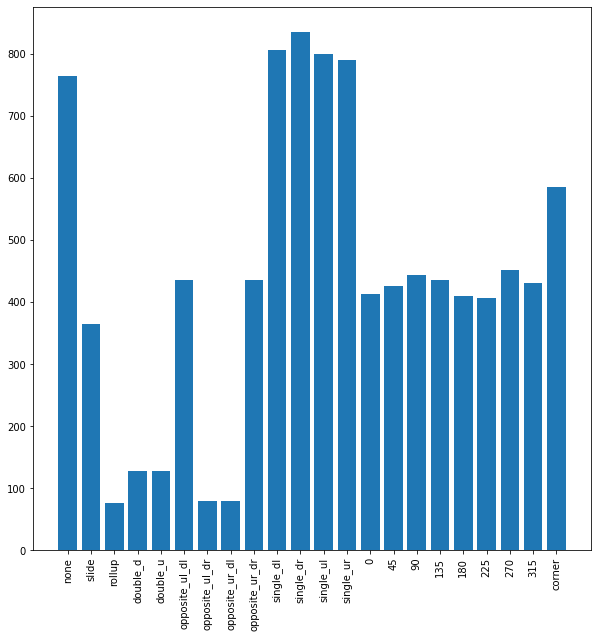

In [46]:
plt.figure(figsize=(10, 10))
plt.xticks(rotation='vertical')
plt.bar(range(len(d_val)), list(d_val.values()), tick_label=list(d_val.keys()))